# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import time
import re
import joblib

import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# load data from database
engine = create_engine('sqlite:///data/Disaster_Response.db')
df = pd.read_sql_table('messages', engine)
X = df['message']
category_names = list(df.columns[3:])
Y = df[category_names]

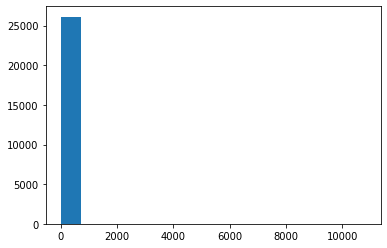

In [3]:
plt.hist([len(df['message'][i]) for i in range(df.shape[0])], bins=15);

In [9]:
for i in range(df.shape[0]):
    df['length'][i]=len(df['message'][i])

D:\Temp/ipykernel_5604/769983238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'][i]=len(df['message'][i])


In [13]:
df[df['length']>5000]

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,length
13864,"One year ago, when a catastrophic earthquake h...",None,news,1,0,0,1,0,1,0,...,1,1,1,1,1,1,0,1,0,6313
15120,The peak for dengue cases is generally during ...,None,news,1,0,0,1,1,0,0,...,0,1,1,1,0,0,0,0,0,5149
16032,The weather forecast indicates that rains shou...,None,news,1,0,0,1,1,0,0,...,0,1,1,1,0,1,1,1,0,10571
17328,"Two years back, I took voluntary retirement to...",None,news,1,0,0,1,1,1,1,...,1,1,1,1,0,1,0,1,0,5783
19392,It is difficult to assess what all of this mea...,None,news,1,0,0,1,1,1,1,...,0,1,1,1,1,0,0,0,0,6951
20649,"Emerging viral diseases such as ebola, marburg...",None,news,1,0,0,1,1,1,0,...,0,1,1,1,0,1,0,0,0,6144
20844,While the focus is to save lives and fight dis...,None,news,1,1,0,1,1,1,0,...,1,1,1,1,0,1,0,1,0,10818
21076,A longer-term strategy for the reform of the e...,None,news,1,0,0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,5052
24809,The sea level increased overnight and in some ...,None,news,1,0,0,1,1,1,0,...,0,1,0,0,0,1,0,0,0,6510
24929,It is hard to stay here; life is doubly diffic...,None,news,1,1,0,1,1,1,1,...,0,1,1,0,0,0,0,0,1,5451


### 2. Write a tokenization function to process your text data

In [19]:
def tokenize(text):
    
    # Replace URLs with string 'urlsupplied'
    urlregex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urlsupplied_text = re.sub(urlregex, 'urlsupplied', text)
    
    # remove punctuation and convert to small letters
    small_unpunc_text = re.sub(r"[^A-Za-z0-9']", ' ', urlsupplied_text).lower()
    
    # tokenize text   
    tokenized_text = word_tokenize(small_unpunc_text)
    
    # lemmatize test
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for item in tokenized_text:
        lemmatized_text.append(lemmatizer.lemmatize(item))
    
    return lemmatized_text

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [20]:
pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize, lowercase=False)),
    ("tfidf", TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=17)

pipeline.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False,
                                 tokenizer=<function tokenize at 0x000001FF581D2550>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [18]:
pipeline.set_params({'vect__ngram_range': (1, 2),
 'vect__max_df': 0.6,
 'clf__estimator__n_estimators': 100,
 'clf__estimator__min_samples_split': 8,
 'clf__estimator__min_samples_leaf': 1})

TypeError: set_params() takes 1 positional argument but 2 were given

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [27]:
def get_model_scores(fittedmodel, X_test, Y_test, category_names):
    '''
    Iterates over columns of response variables. Prints macro and weighted average f1_Score, recall and precision.
    INPUTS:
    fittedmodel - sci-kit learn classifier object that should already have been fitted with the data.
    X_test (1d numpy array, pandas series) - explanatory variables you wish to test the model with.
    Y_test (2d numpy array, pandas df) - reponse variables you wish to test the model with.
    OUTPUTS:
    -
    '''
    predictions = fittedmodel.predict(X_test)
    
    f1_scores_m = []
    precision_scores_m = []
    recall_scores_m = []
    f1_scores_w = []
    precision_scores_w = []
    recall_scores_w = []
    
    for i in range(Y_test.shape[1]):
    
        score_dict = classification_report(predictions[:][i], np.array(Y_test)[:][i], 
                                                      zero_division=0, output_dict=True)
        
        f1_scores_m.append(score_dict['macro avg']['f1-score'])
        precision_scores_m.append(score_dict['macro avg']['precision'])
        recall_scores_m.append(score_dict['macro avg']['recall'])
        f1_scores_w.append(score_dict['weighted avg']['f1-score'])
        precision_scores_w.append(score_dict['weighted avg']['precision'])
        recall_scores_w.append(score_dict['weighted avg']['recall'])
        
        print("Scores in category \'{}\':".format(category_names[i]))
        print("    f1 score:  {:.2f}.".format(f1_scores_m[-1]))
        print("    Precision: {:.2f}.".format(precision_scores_m[-1]))
        print("    Recall:    {:.2f}.".format(recall_scores_m[-1]))
    
    print("\nAverage macro f1 score is {:.2f}.".format(np.array(f1_scores_m).mean()))
    print("Average macro precision score is {:.2f}.".format(np.array(precision_scores_m).mean()))
    print("Average macro recall score is {:.2f}.".format(np.array(recall_scores_m).mean()))
    print("Average weighted f1 score is {:.2f}.".format(np.array(f1_scores_w).mean()))
    print("Average weighted precision score is {:.2f}.".format(np.array(precision_scores_w).mean()))
    print("Average weighted recall score is {:.2f}.".format(np.array(recall_scores_w).mean()))
       
    return None

get_model_scores(pipeline, X_test, Y_test, category_names)

Scores in category 'related':
    f1 score:  0.80.
    Precision: 0.77.
    Recall:    0.85.
Scores in category 'request':
    f1 score:  0.81.
    Precision: 0.75.
    Recall:    0.95.
Scores in category 'offer':
    f1 score:  0.68.
    Precision: 0.62.
    Recall:    0.96.
Scores in category 'aid_related':
    f1 score:  1.00.
    Precision: 1.00.
    Recall:    1.00.
Scores in category 'medical_help':
    f1 score:  0.49.
    Precision: 0.49.
    Recall:    0.50.
Scores in category 'medical_products':
    f1 score:  0.91.
    Precision: 0.88.
    Recall:    0.97.
Scores in category 'search_and_rescue':
    f1 score:  0.49.
    Precision: 0.49.
    Recall:    0.50.
Scores in category 'security':
    f1 score:  0.49.
    Precision: 0.47.
    Recall:    0.50.
Scores in category 'military':
    f1 score:  0.92.
    Precision: 0.98.
    Recall:    0.88.
Scores in category 'child_alone':
    f1 score:  0.89.
    Precision: 0.83.
    Recall:    0.99.
Scores in category 'water':
    f1 sco

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = {
 'vect__max_df': [0.2, 0.4, 0.6],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'clf__estimator__min_samples_leaf': [2, 4],
 'clf__estimator__min_samples_split': [4, 8, 12],
 'clf__estimator__n_estimators': [50, 100, 200]
}

rand_search_cv = RandomizedSearchCV(estimator = pipeline, param_distributions = parameters, n_jobs=-1, 
                                    random_state=17, verbose=5, n_iter = 30)
start_time = time.time()
rand_search_cv.fit(X_train, Y_train)
time_taken = time.time() - start_time
print("That took {} minutes and {:.1f} seconds.".format(time_taken//60, time_taken%60))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [25]:
pipeline.set_params(vect__max_df=0.2)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, max_df=0.2,
                                 stop_words='english',
                                 tokenizer=<function tokenize at 0x000001E74A8A3940>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [26]:
best_parameters

{'vect__ngram_range': (1, 2),
 'vect__max_df': 0.2,
 'clf__estimator__n_estimators': 200,
 'clf__estimator__min_samples_split': 4,
 'clf__estimator__min_samples_leaf': 2}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [10]:
get_model_scores(rand_search_cv, X_test, Y_test)

Average macro f1 score is 0.80.
Average macro precision score is 0.79.
Average macro recall score is 0.86.
Average weighted f1 score is 0.96.
Average weighted precision score is 0.97.
Average weighted recall score is 0.96.


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [13]:
with open("./classifier.pkl", "wb") as f:
    joblib.dump(rand_search_cv, f, compress='zlib')

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.